In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler

In [2]:
results_ls = pd.read_csv('logs/results4_link_state.csv')
results_sq = pd.read_csv('logs/results4_sq.csv')
results_pq = pd.read_csv('logs/results4_pq.csv')
results_dqn = pd.read_csv('logs/results4_dqn.csv')

In [3]:
results_ls.head()

,Unnamed: 0,time,count,avg,min,max
0,0,0.0,10.0,35.80,21.0,55.0
1,1,500.0,25.0,44.16,21.0,70.0
2,2,1000.0,25.0,41.64,21.0,70.0
3,3,1500.0,25.0,42.32,21.0,70.0
4,4,2000.0,25.0,44.80,21.0,85.0


In [4]:
results_dqn.head()

,Unnamed: 0,time,count,avg,min,max
0,0,0.0,10.0,37.40,21.0,62.0
1,1,500.0,25.0,44.16,21.0,70.0
2,2,1000.0,25.0,41.68,21.0,70.0
3,3,1500.0,25.0,42.36,21.0,70.0
4,4,2000.0,25.0,44.84,21.0,85.0


In [5]:
def setAxLinesBW(ax):
    """
    Take each Line2D in the axes, ax, and convert the line style to be 
    suitable for black and white viewing.
    """
    MARKERSIZE = 3

    COLORMAP = {
        'b': {'marker': None, 'dash': (None,None)},
        'g': {'marker': None, 'dash': [5,5]},
        'r': {'marker': None, 'dash': [5,3,1,3]},
        'c': {'marker': None, 'dash': [1,3]},
        'm': {'marker': None, 'dash': [5,2,5,2,5,10]},
        'y': {'marker': None, 'dash': [5,3,1,2,1,10]},
        'k': {'marker': 'o', 'dash': (None,None)} #[1,2,1,10]}
        }


    lines_to_adjust = ax.get_lines()
    try:
        lines_to_adjust += ax.get_legend().get_lines()
    except AttributeError:
        pass

    for line in lines_to_adjust:
        origColor = line.get_color()
        line.set_color('black')
        line.set_dashes(COLORMAP[origColor]['dash'])
        line.set_marker(COLORMAP[origColor]['marker'])
        line.set_markersize(MARKERSIZE)

In [6]:
def read_multi_run(file, n=3, prefixes=['']):
    final_df = None
    for prefix in prefixes:
        avg_c = 'avg' if prefix=='' else prefix+'_avg'
    
        df = pd.read_csv(file.format(1))
        df = df[['time', avg_c]]
        avg_cols = [avg_c]
    
        for i in range(2, n+1):
            df2 = pd.read_csv(file.format(i))
            acol = avg_c+str(i)
            df[acol] = df2[avg_c]
            avg_cols.append(acol)
        
        df[avg_c+'_total'] = df.apply(lambda row: np.mean([row[acol] for acol in avg_cols]), axis=1)
        df[avg_c+'_max'] = df.apply(lambda row: np.amax([row[acol] for acol in avg_cols]), axis=1)
        df[avg_c+'_min'] = df.apply(lambda row: np.amin([row[acol] for acol in avg_cols]), axis=1)
        df = df.drop(avg_cols, axis=1)
        if final_df is None:
            final_df = df
        else:
            final_df = final_df.merge(df, on='time')
    return final_df
    

In [7]:
df = read_multi_run('logs/results6/link_state.{}.csv', 3)

In [8]:
df.head()

,time,avg_total,avg_max,avg_min
0,0.0,41.176190,48.000000,36.428571
1,500.0,46.096677,50.576923,43.019231
2,1000.0,46.614705,48.122449,45.541667
3,1500.0,51.994184,53.627451,50.600000
4,2000.0,51.110878,53.058824,49.416667


In [9]:
color_c = cycler('color', ['k'])
style_c = cycler('linestyle', ['-', '--', ':', '-.'])
markr_c = cycler('marker', ['', 'v', 'o'])
c_cms = color_c * markr_c * style_c

In [33]:
def plot_graph(title, ress, prefix='', figsize=(13, 6), ylim=None, xlim=None,
               xlabel='Time of simulation model', ylabel='Average packet delivery time',
               legend_size=18, font_size=24, tick_size=14, color=False, save_path=None):
    min_avg = 10000000
    max_avg = 0
    f= plt.figure(figsize=figsize)
    avg_col = 'avg' if prefix=='' else prefix+'_avg'
    
    if color:
        plt.gca().set_prop_cycle(None)
    else:
        plt.gca().set_prop_cycle(c_cms)
        
    plt.rc('xtick', labelsize=tick_size)
    plt.rc('ytick', labelsize=tick_size)
    
    for (label, res) in ress:
        min_avg = min(min_avg, np.amin(res[avg_col]))
        max_avg = max(max_avg, np.amax(res[avg_col]))
        res.drop_duplicates('time', keep='last', inplace=True)
        plt.plot(res['time'], res[avg_col] ,label=label, alpha=0.5)
    plt.xlabel(xlabel, fontsize=font_size)
    plt.ylabel(ylabel, fontsize=font_size)
    plt.legend(prop={'size':legend_size})
    
    if ylim is None:
        plt.ylim((min_avg - 15, max_avg + 15))
    else:
        plt.ylim(ylim)
        
    if xlim is not None:
        plt.xlim(xlim)

    plt.title(title, fontsize=font_size)
    plt.show()
    
    if save_path is not None:
        f.savefig(save_path, bbox_inches='tight')
    
def plot_multi_graph(title, ress, prefix='', figsize=(13, 8), ylim=None, xlim=None,
               xlabel='Time of simulation model', ylabel='Average packet delivery time',
               legend_size=18, font_size=24, tick_size=14, lw=3, elw=2,
               color=False, save_path=None):
    plt.gca().set_prop_cycle(None)
    min_avg = 10000000
    max_avg = 0
    f = plt.figure(figsize=figsize)
    avg_pref = 'avg' if prefix=='' else prefix+'_avg'
    
    for ((label, res), prop) in zip(ress, c_cms):
        min_avg = min(min_avg, np.amin(res[avg_pref+'_total']))
        max_avg = max(max_avg, np.amax(res[avg_pref+'_total']))
        minerr = res[avg_pref+'_total'] - res[avg_pref+'_min']
        maxerr = res[avg_pref+'_max'] - res[avg_pref+'_total']
        
        plt_kwargs = {"yerr": [minerr, maxerr], "label": label, "alpha": 0.5,
                      "linewidth": lw, "elinewidth": elw}
        if not color:
            plt_kwargs["color"] = prop['color']
            plt_kwargs["ls"] = prop['linestyle']
            plt_kwargs["marker"] = prop['marker']
            
        eb = plt.errorbar(res['time'], res[avg_pref+'_total'], **plt_kwargs)
        if not color:
            eb[-1][0].set_linestyle(prop['linestyle'])
        #plt.plot(res['time'], res[avg_pref+'_total'], label=label, alpha=0.5)
        #plt.fill_between(res['time'], res[avg_pref+'_max'], res[avg_pref+'_min'], alpha=0.15)
    plt.xlabel(xlabel, fontsize=font_size)
    plt.ylabel(ylabel, fontsize=font_size)
    plt.rc('xtick', labelsize=tick_size)
    plt.rc('ytick', labelsize=tick_size)
    plt.legend(prop={'size':legend_size})
    
    if ylim is None:
        plt.ylim((min_avg - 15, max_avg + 15))
    else:
        plt.ylim(ylim)
        
    if xlim is not None:
        plt.xlim(xlim)
    
    plt.title(title, fontsize=font_size)
    plt.show()
    
    if save_path is not None:
        f.savefig(save_path, bbox_inches='tight')
    

In [11]:
def count_mean_multi(ress, f=np.mean, prefix=''):
    avg_pref = 'avg' if prefix=='' else prefix+'_avg'
    df = pd.DataFrame(columns=list(zip(*ress))[0])
    ms = []
    for (label, res) in ress:
        ms.append(round(f(res[avg_pref+'_total']), 1))
    df.loc[0] = ms
    return df

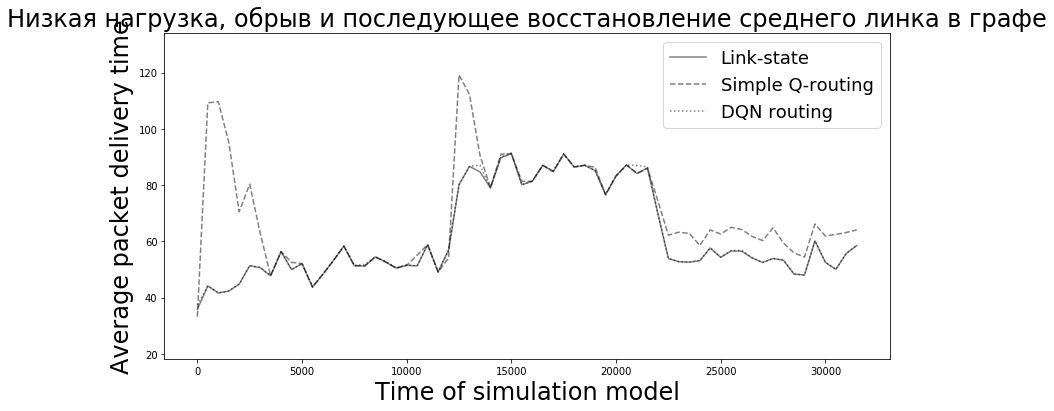

In [12]:
title = 'Низкая нагрузка, обрыв и последующее восстановление среднего линка в графе'
plot_graph(title, ress=[('Link-state', results_ls), ('Simple Q-routing', results_sq), ('DQN routing', results_dqn)])

In [13]:
results2_ls = pd.read_csv('logs/results6_link_state.csv')
results2_sq = pd.read_csv('logs/results6_sq.csv')
#results2_pq = pd.read_csv('logs/results6_pq.csv')
results2_dqn = pd.read_csv('logs/results6/dqn.3.csv')
#results2_dqn_out_links = pd.read_csv('logs/results6_dqn_out_links.csv')
#results2_dqn_adviced = pd.read_csv('logs/results6_dqn_advice_2.csv')
#results2_dqn_load_states = pd.read_csv('logs/results6_dqn_load_states.csv')
results2_dqn_adam = pd.read_csv('logs/results6/dqn_adam.3.csv')
results2_dqn_rnn = pd.read_csv('logs/results6/dqn_32x2.3.csv')

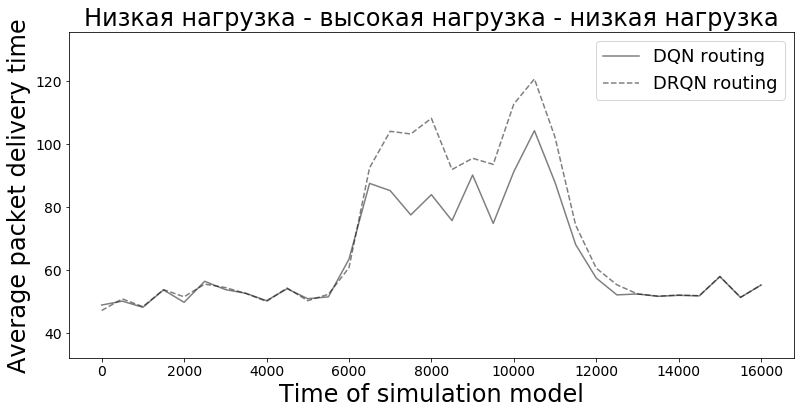

In [14]:
title = 'Низкая нагрузка - высокая нагрузка - низкая нагрузка'
plot_graph(title, ress=[('DQN routing', results2_dqn),# ('DQN (AdamOptimizer)', results2_dqn_adam),
                        ('DRQN routing', results2_dqn_rnn)])

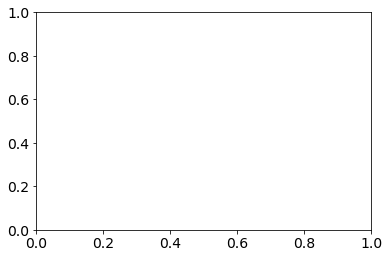

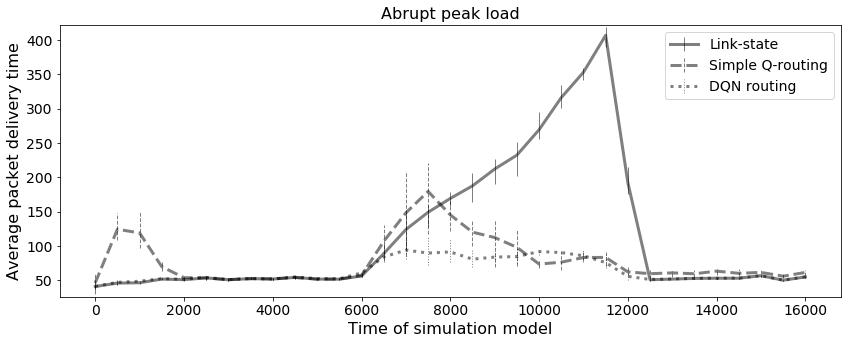

   Link-state  Simple Q-routing  DQN routing
0       114.8              79.3         63.9


In [16]:
results6_multi_ls = read_multi_run('logs/results6/link_state.{}.csv', 3)
results6_multi_sq = read_multi_run('logs/results6/simple_q.{}.csv', 3)
results6_multi_dqn = read_multi_run('logs/results6/dqn_tanh.{}.csv', 3)
ress=[('Link-state', results6_multi_ls),
      ('Simple Q-routing', results6_multi_sq),
      ('DQN routing', results6_multi_dqn)]
plot_multi_graph('Abrupt peak load', ress, elw=1, font_size=16, legend_size=14, color=False, figsize=(14,5),
                 save_path="peak-load-main_bw.pdf")
print(count_mean_multi(ress))

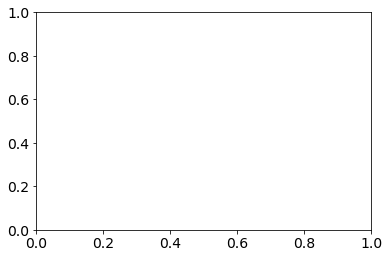

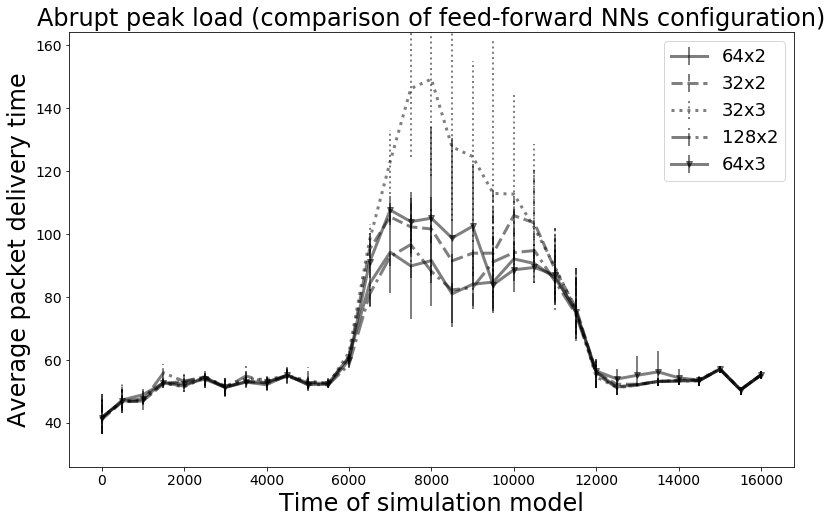

   64x2  32x2  32x3  128x2  64x3
0  63.9  67.1  73.3   64.2  66.5


In [17]:
results6_multi_dqn_32x2 = read_multi_run('logs/results6/dqn_32x2.{}.csv', 3)
results6_multi_dqn_32x3 = read_multi_run('logs/results6/dqn_32x3.{}.csv', 3)
results6_multi_dqn_128x2 = read_multi_run('logs/results6/dqn_128x2.{}.csv', 3)
results6_multi_dqn_64x3 = read_multi_run('logs/results6/dqn_64x3.{}.csv', 3)
ress=[('64x2', results6_multi_dqn),
                       ('32x2', results6_multi_dqn_32x2),
                       ('32x3', results6_multi_dqn_32x3),
                       ('128x2', results6_multi_dqn_128x2),
                       ('64x3', results6_multi_dqn_64x3)]
plot_multi_graph('Abrupt peak load (comparison of feed-forward NNs configuration)', ress)
print(count_mean_multi(ress))

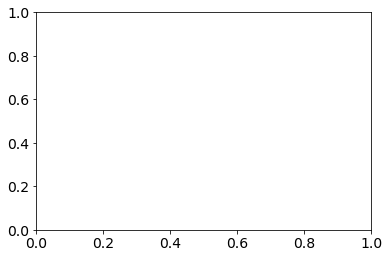

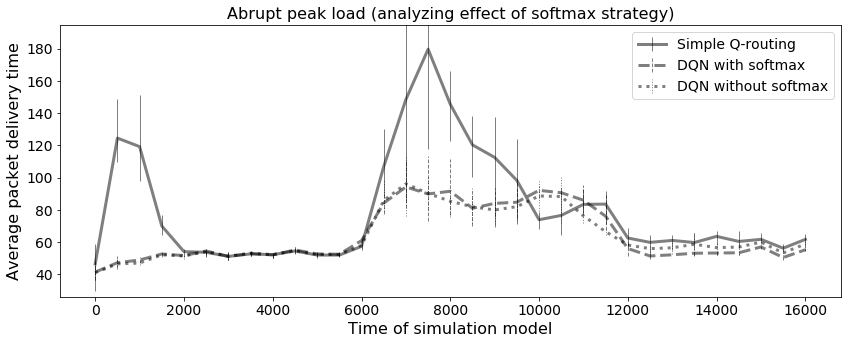

In [19]:
results6_multi_dqn_no_softmax = read_multi_run('logs/results6/dqn_no_softmax.{}.csv', 3)
plot_multi_graph('Abrupt peak load (analyzing effect of softmax strategy)',
                 ress=[('Simple Q-routing', results6_multi_sq),
                       ('DQN with softmax', results6_multi_dqn),
                       ('DQN without softmax', results6_multi_dqn_no_softmax)],
                 elw=1, font_size=16, legend_size=14, color=False, figsize=(14,5), save_path="softmax-comparison_bw.pdf")

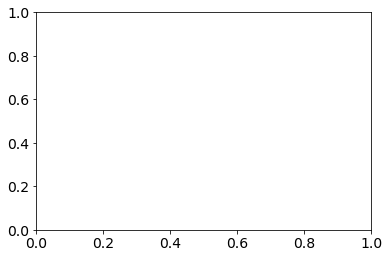

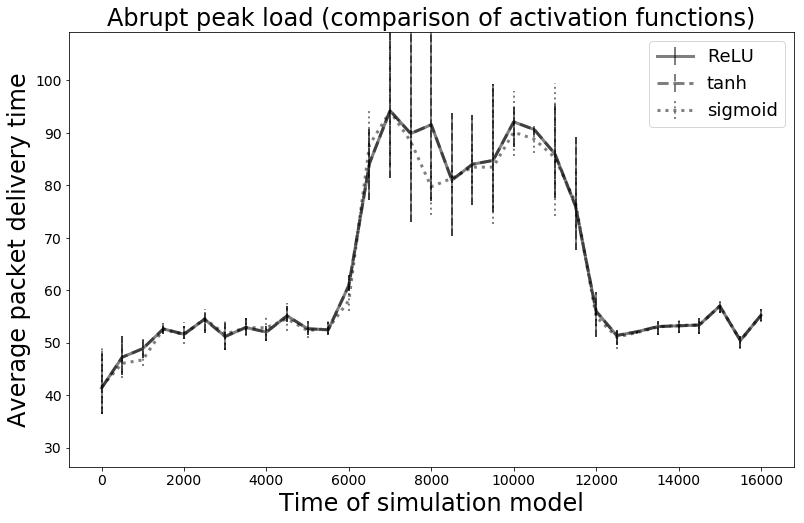

In [20]:
results6_multi_dqn_tanh = read_multi_run('logs/results6/dqn_tanh.{}.csv', 3)
results6_multi_dqn_sigmoid = read_multi_run('logs/results6/dqn_sigmoid.{}.csv', 3)
plot_multi_graph('Abrupt peak load (comparison of activation functions)',
                 ress=[('ReLU', results6_multi_dqn),
                       ('tanh', results6_multi_dqn_tanh),
                       ('sigmoid', results6_multi_dqn_sigmoid)])

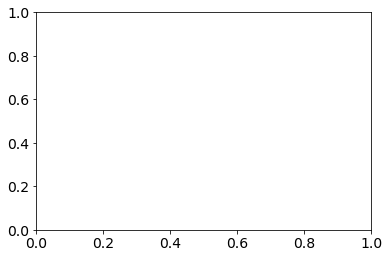

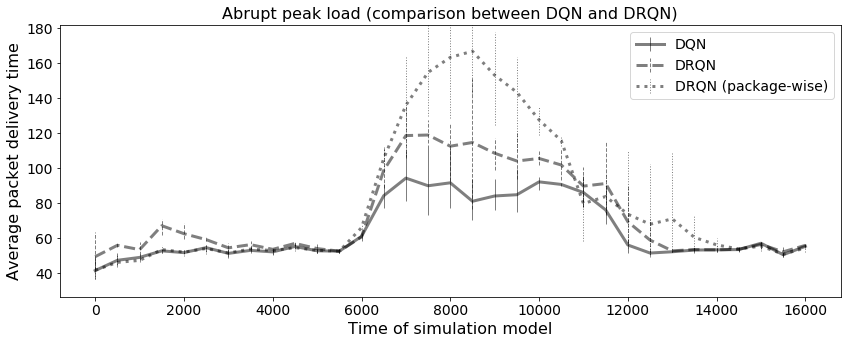

    DQN  DRQN  DRQN (package-wise)
0  63.9  72.8                 80.3


In [24]:
results6_multi_dqn_rnn = read_multi_run('logs/results6/dqn_rnn.{}.csv', 3)
results6_multi_dqn_rnn_pp = read_multi_run('logs/results6/dqn_rnn_per_pkg.{}.csv', 3)
ress=[('DQN', results6_multi_dqn),
                       ('DRQN', results6_multi_dqn_rnn),
                       ('DRQN (package-wise)', results6_multi_dqn_rnn_pp)]
plot_multi_graph('Abrupt peak load (comparison between DQN and DRQN)', ress,
                 elw=1, font_size=16, legend_size=14, color=False, figsize=(14,5), save_path="peak-load-nns_bw.pdf")
print(count_mean_multi(ress))

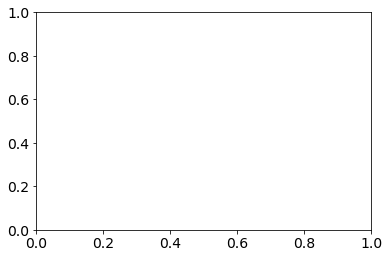

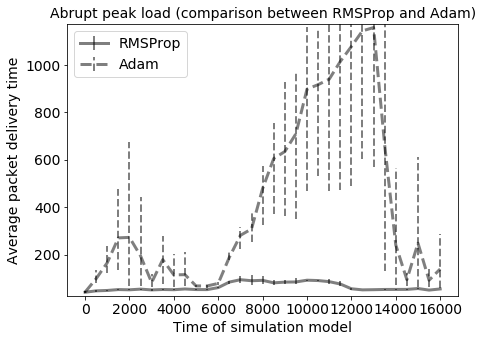

In [25]:
results6_multi_dqn_adam = read_multi_run('logs/results6/dqn_adam.{}.csv', 3)
plot_multi_graph('Abrupt peak load (comparison between RMSProp and Adam)', figsize=(7, 5),
                 font_size=14, tick_size=10, legend_size=14, color=False,
                 ress=[('RMSProp', results6_multi_dqn),
                       ('Adam', results6_multi_dqn_adam)], save_path="adam-vs-rmsprop_bw.pdf")

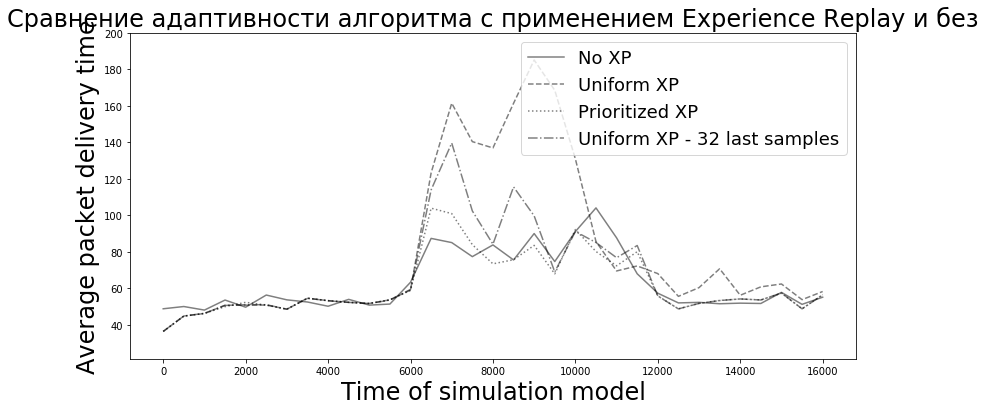

In [26]:
results2_dqn_2 = pd.read_csv('logs/results6_dqn_uniform_xp.csv')
results2_dqn_3 = pd.read_csv('logs/results6_xp_tests/dqn_prioritized_xp_last32.1.csv')
results2_dqn_4 = pd.read_csv('logs/results6_dqn_uniform_xp_last32.csv')
title = 'Сравнение адаптивности алгоритма с применением Experience Replay и без'
plot_graph(title, ress=[('No XP', results2_dqn), ('Uniform XP', results2_dqn_2),
                        ('Prioritized XP', results2_dqn_3), ('Uniform XP - 32 last samples', results2_dqn_4)])

In [27]:
results6_xp_multi_dqn = read_multi_run('logs/results6/dqn_tanh.{}.csv', 3)
results6_xp_multi_dqn_uniform_xp = read_multi_run('logs/results6_xp_tests/dqn_uniform_xp.{}.csv', 3)
results6_xp_multi_dqn_prioritized_xp = read_multi_run('logs/results6_xp_tests/dqn_prioritized_xp.{}.csv', 3)
results6_xp_multi_dqn_prioritized_xp_last32 = read_multi_run('logs/results6_xp_tests/dqn_prioritized_xp_last32.{}.csv', 3)
results6_xp_multi_dqn_last32_xp = read_multi_run('logs/results6_xp_tests/dqn_last32_xp.{}.csv', 3)

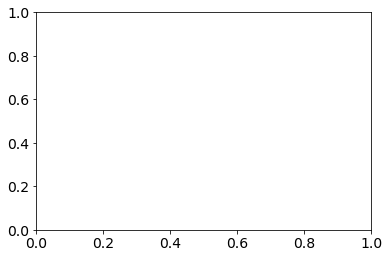

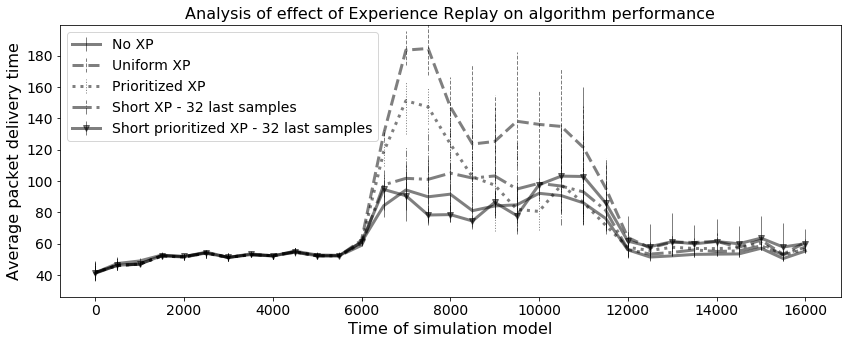

In [29]:
title = 'Analysis of effect of Experience Replay on algorithm performance'
plot_multi_graph(title, ress=[('No XP', results6_xp_multi_dqn), ('Uniform XP', results6_xp_multi_dqn_uniform_xp),
                              ('Prioritized XP', results6_xp_multi_dqn_prioritized_xp),
                              ('Short XP - 32 last samples', results6_xp_multi_dqn_last32_xp),
                              ('Short prioritized XP - 32 last samples', results6_xp_multi_dqn_prioritized_xp_last32)],
                 elw=1, font_size=16, legend_size=14, color=False, figsize=(14,5), save_path="xp-comparison_bw.pdf")

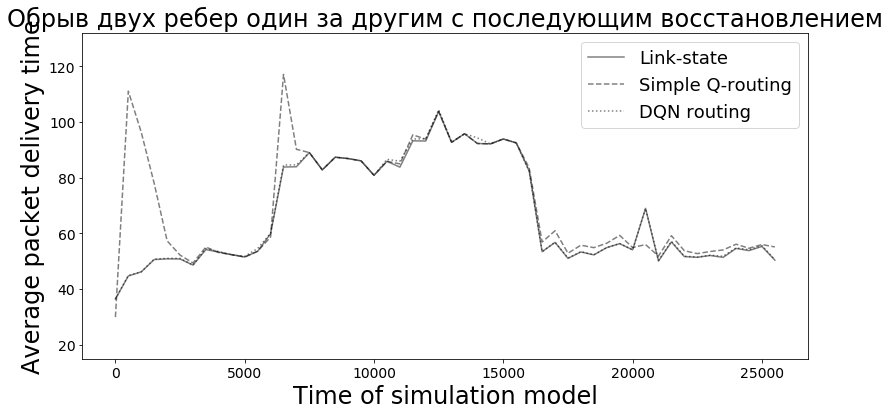

In [30]:
results3_ls = pd.read_csv('logs/results7_ls.csv')
results3_sq = pd.read_csv('logs/results7_sq.csv')
results3_dqn = pd.read_csv('logs/results7_dqn.csv')
title = 'Обрыв двух ребер один за другим с последующим восстановлением'
plot_graph(title, ress=[('Link-state', results3_ls), ('Simple Q-routing', results3_sq), ('DQN routing', results3_dqn)])

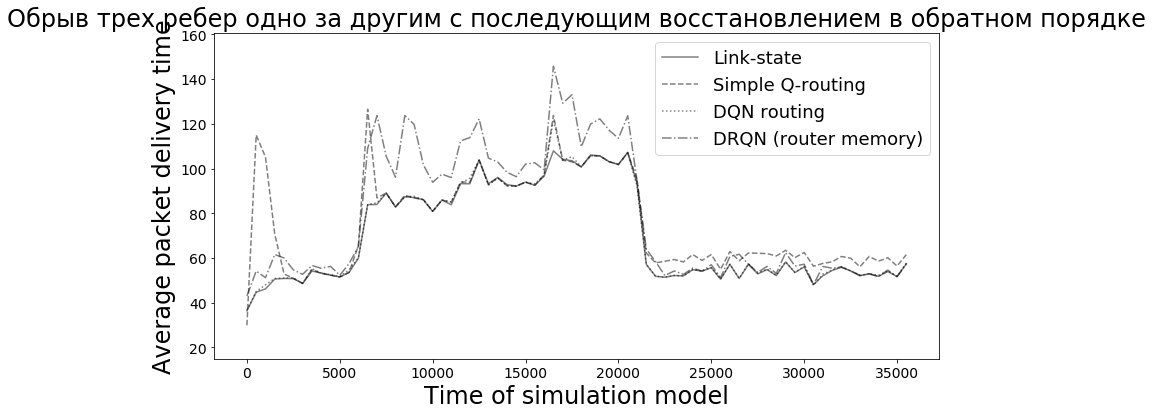

In [31]:
results4_ls = pd.read_csv('logs/results8/link_state.1.csv')
results4_sq = pd.read_csv('logs/results8/simple_q.1.csv')
results4_dqn = pd.read_csv('logs/results8/dqn.1.csv')
resutls4_dqn_rnn = pd.read_csv('logs/results8/dqn_rnn.1.csv')
title = 'Обрыв трех ребер одно за другим с последующим восстановлением в обратном порядке'
plot_graph(title, ress=[('Link-state', results4_ls), ('Simple Q-routing', results4_sq),
            ('DQN routing', results4_dqn), ('DRQN (router memory)', resutls4_dqn_rnn)])

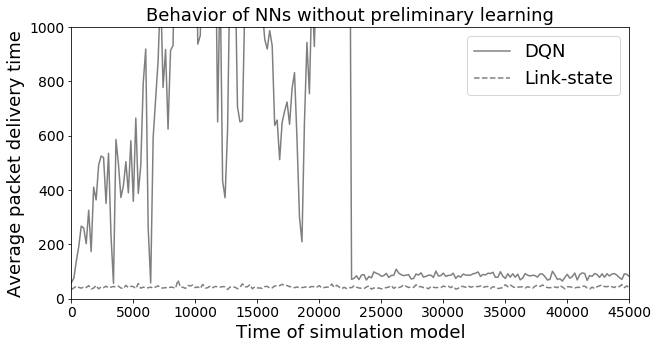

In [35]:
results_no_pretrain = pd.read_csv('logs/results5_no_pretrain_dqn.csv')
results5_ls = pd.read_csv('logs/results5_link_state.csv')
plot_graph('Behavior of NNs without preliminary learning', ress=[('DQN', results_no_pretrain), ('Link-state', results5_ls)],
           xlim=(0, 45000), ylim=(0, 1000), font_size=18, tick_size=14, figsize=(10, 5), color=False,
           save_path="no-pretrain-divergence_bw.pdf")

In [36]:
results6_ls = pd.read_csv('logs/results10_ls.csv')
results6_sq = pd.read_csv('logs/results10_sq.csv')
#results2_pq = pd.read_csv('logs/results6_pq.csv')
results6_dqn = pd.read_csv('logs/results10_dqn.csv')
results6_dqn_out_links = pd.read_csv('logs/results10_dqn_out_links.csv')
results6_dqn_adviced = pd.read_csv('logs/results10_dqn_advice_2.csv')

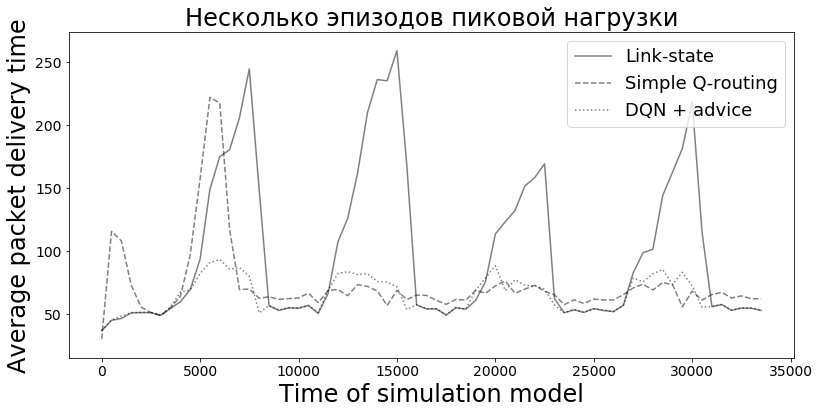

In [37]:
title = 'Несколько эпизодов пиковой нагрузки'
plot_graph(title, ress=[('Link-state', results6_ls), ('Simple Q-routing', results6_sq),
          ('DQN + advice', results6_dqn_adviced)])

In [38]:
results8_multi_ls = read_multi_run('logs/results8/link_state.{}.csv', 3)
results8_multi_sq = read_multi_run('logs/results8/simple_q.{}.csv', 3)
results8_multi_dqn = read_multi_run('logs/results8/dqn.{}.csv', 3)

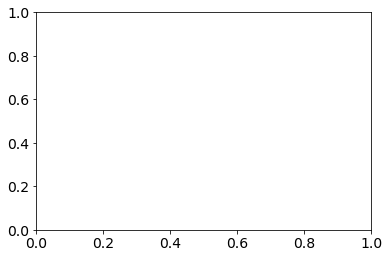

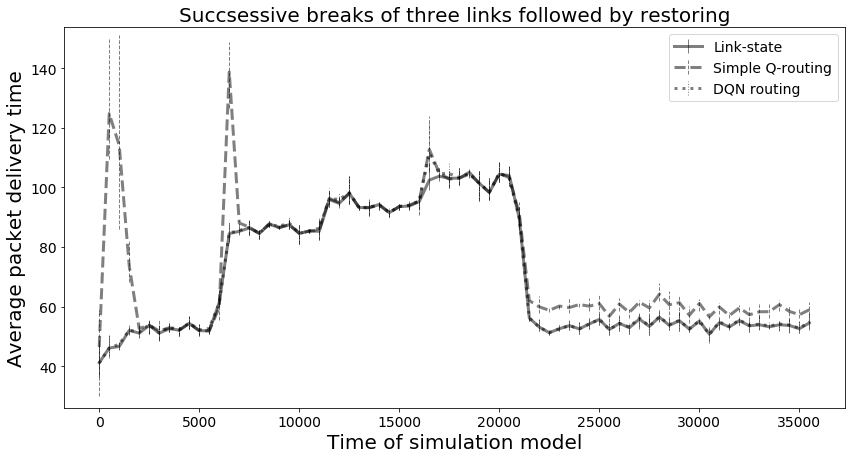

   Link-state  Simple Q-routing  DQN routing
0        70.0              75.7         70.3


In [40]:
title = 'Succsessive breaks of three links followed by restoring'
ress=[('Link-state', results8_multi_ls), ('Simple Q-routing', results8_multi_sq),
          ('DQN routing', results8_multi_dqn)]
plot_multi_graph(title, ress, elw=1, font_size=20, legend_size=14, color=False, figsize=(14,7),
                 save_path="topology-change-main_bw.pdf")
print(count_mean_multi(ress))

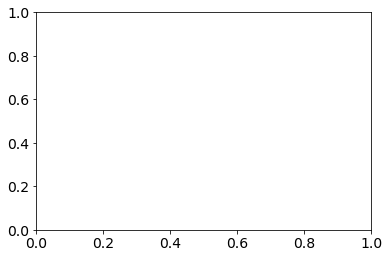

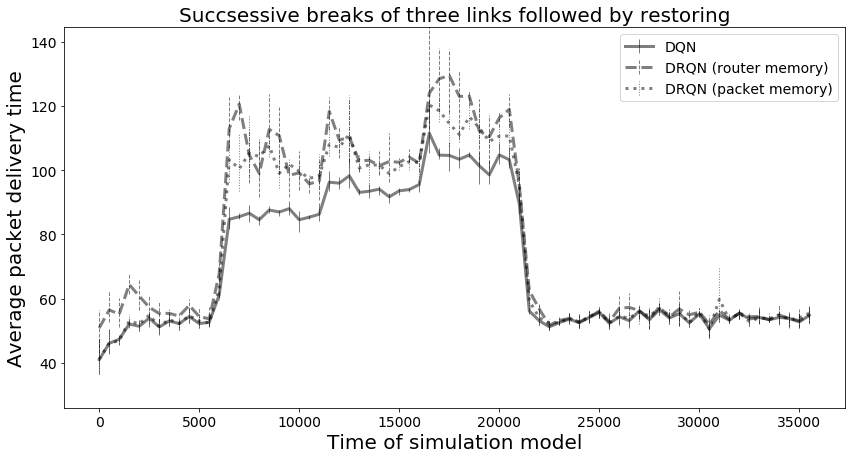

    DQN  DRQN (router memory)  DRQN (packet memory)
0  70.3                  78.2                  75.4


In [42]:
results8_multi_dqn_rnn = read_multi_run('logs/results8/dqn_rnn.{}.csv')
results8_multi_dqn_rnn_per_pkg = read_multi_run('logs/results8/dqn_rnn_per_pkg.{}.csv')
ress=[('DQN', results8_multi_dqn),
                       ('DRQN (router memory)', results8_multi_dqn_rnn),
                       ('DRQN (packet memory)', results8_multi_dqn_rnn_per_pkg)]
 #('DQN with upper triangle', results8_multi_dqn_matrix_tr)]
plot_multi_graph('Succsessive breaks of three links followed by restoring', ress,
                 elw=1, font_size=20, legend_size=14, color=False, figsize=(14,7),
                 save_path="topology-change-nns_bw.pdf")
print(count_mean_multi(ress))

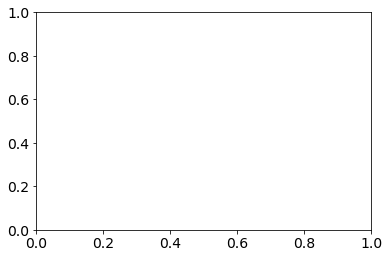

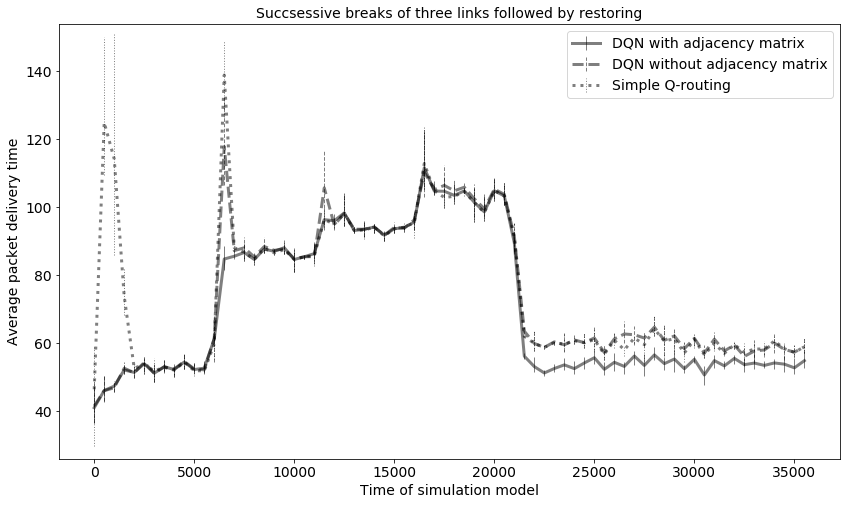

   DQN with adjacency matrix  DQN without adjacency matrix  Simple Q-routing
0                       70.3                          73.5              75.7


In [43]:
results8_multi_dqn_nomatrix = read_multi_run('logs/results8/dqn_new_none.{}.csv', 3)
results8_multi_dqn_matrix_tr = read_multi_run('logs/results8/dqn_new_amatrix_tr.{}.csv', 3)
#results8_dqn_matrix = pd.read_csv('logs/results8/dqn.1.csv')
ress=[('DQN with adjacency matrix', results8_multi_dqn),
                       ('DQN without adjacency matrix', results8_multi_dqn_nomatrix),
                       ('Simple Q-routing', results8_multi_sq)]
#('DQN with upper triangle', results8_multi_dqn_matrix_tr)]
plot_multi_graph('Succsessive breaks of three links followed by restoring', ress,
                 elw=1, font_size=14, legend_size=14, color=False, figsize=(14,8))
print(count_mean_multi(ress))

In [44]:
results10_multi_ls = read_multi_run('logs/results10/link_state.{}.csv', 3)
results10_multi_sq = read_multi_run('logs/results10/simple_q.{}.csv', 3)
results10_multi_dqn = read_multi_run('logs/results10/dqn.{}.csv', 3)

/nix/store/qg51qhkhhdz5908820zzqi2dcj3sjmjk-python3.6-numpy-1.15.3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


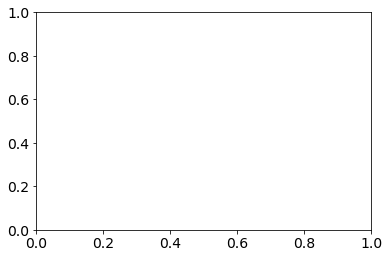

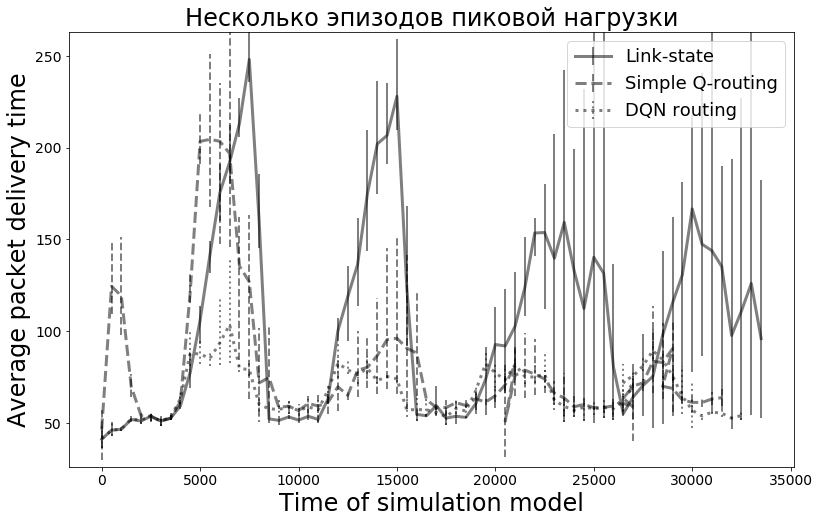

In [45]:
title = 'Несколько эпизодов пиковой нагрузки'
plot_multi_graph(title, ress=[('Link-state', results10_multi_ls), ('Simple Q-routing', results10_multi_sq),
          ('DQN routing', results10_multi_dqn)])

# Конвейеры

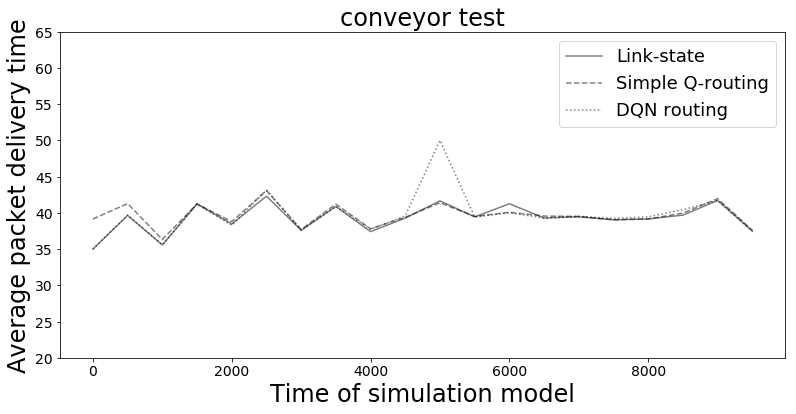

In [46]:
results_conv_test_ls = pd.read_csv('logs/conveyor_test/ls.csv')
results_conv_test_sq = pd.read_csv('logs/conveyor_test/simple_q.csv')
results_conv_test_dqn = pd.read_csv('logs/conveyor_test/dqn.csv')
plot_graph('conveyor test', prefix='time',
           ress=[('Link-state', results_conv_test_ls),
                 ('Simple Q-routing', results_conv_test_sq),
                 ('DQN routing', results_conv_test_dqn)])

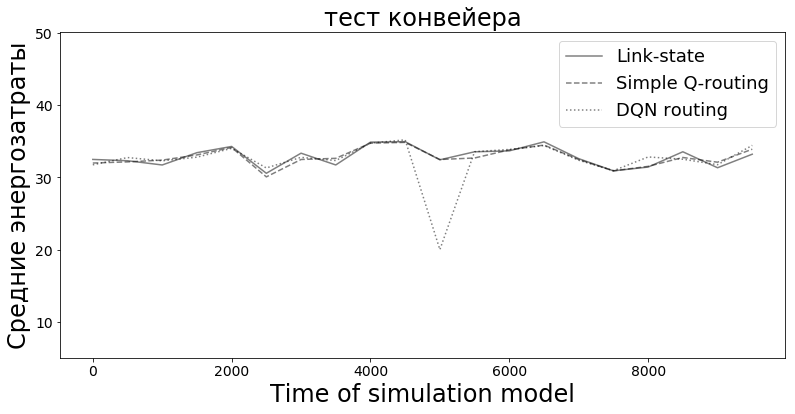

In [47]:
plot_graph('тест конвейера', prefix='energy', ylabel='Средние энергозатраты',
           ress=[('Link-state', results_conv_test_ls),
                 ('Simple Q-routing', results_conv_test_sq),
                 ('DQN routing', results_conv_test_dqn)])

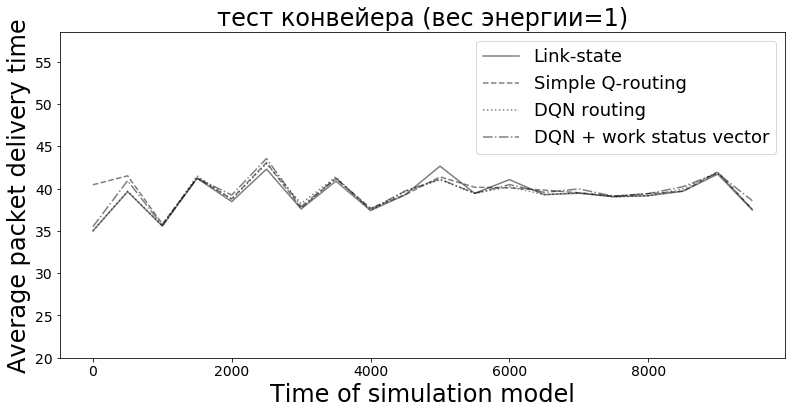

In [48]:
results_conv_test_e1_ls = pd.read_csv('logs/conveyor_test/ls_energy_1.csv')
results_conv_test_e1_sq = pd.read_csv('logs/conveyor_test/simple_q_energy_1.csv')
results_conv_test_e1_dqn = pd.read_csv('logs/conveyor_test/dqn_energy_1.csv')
results_conv_test_e1_ws_dqn = pd.read_csv('logs/conveyor_test/dqn_energy_1_work_status.csv')
plot_graph('тест конвейера (вес энергии=1)', prefix='time',
           ress=[('Link-state', results_conv_test_e1_ls),
                 ('Simple Q-routing', results_conv_test_e1_sq),
                 ('DQN routing', results_conv_test_e1_dqn),
                 ('DQN + work status vector', results_conv_test_e1_ws_dqn)])

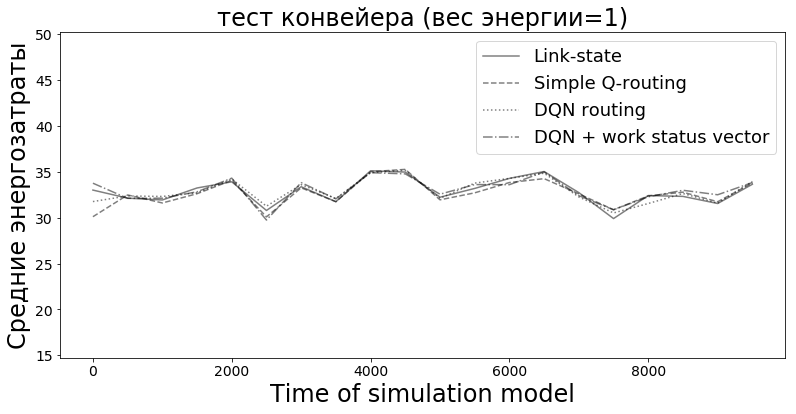

In [49]:
plot_graph('тест конвейера (вес энергии=1)', prefix='energy', ylabel='Средние энергозатраты',
           ress=[('Link-state', results_conv_test_e1_ls),
                 ('Simple Q-routing', results_conv_test_e1_sq),
                 ('DQN routing', results_conv_test_e1_dqn),
                 ('DQN + work status vector', results_conv_test_e1_ws_dqn)])

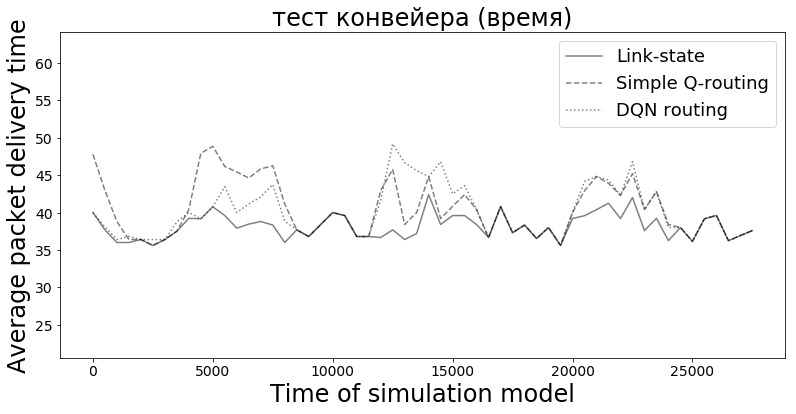

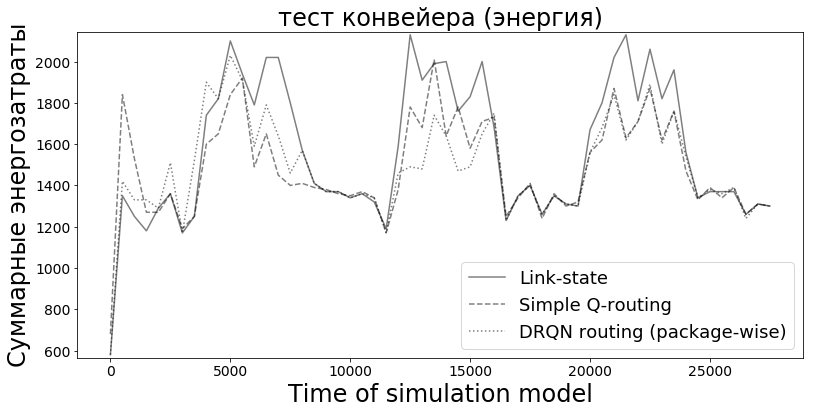

In [50]:
results_conv_ng_test_ls = pd.read_csv('logs/conveyor_energy_test/ls_en1.2.csv')
results_conv_ng_test_sq = pd.read_csv('logs/conveyor_energy_test/simple_q_en1.2.csv')
results_conv_ng_test_dqn = pd.read_csv('logs/conveyor_energy_test/dqn_no_inp.2.csv')
plot_graph('тест конвейера (время)', prefix='time',
           ress=[('Link-state', results_conv_ng_test_ls),
                 ('Simple Q-routing', results_conv_ng_test_sq),
                 ('DQN routing', results_conv_ng_test_dqn)])
plot_graph('тест конвейера (энергия)', prefix='energy', ylabel='Суммарные энергозатраты',
           ress=[('Link-state', results_conv_ng_test_ls),
                 ('Simple Q-routing', results_conv_ng_test_sq),
                 ('DRQN routing (package-wise)', results_conv_ng_test_dqn)])

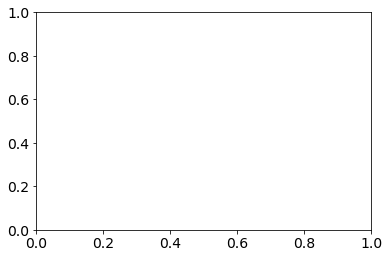

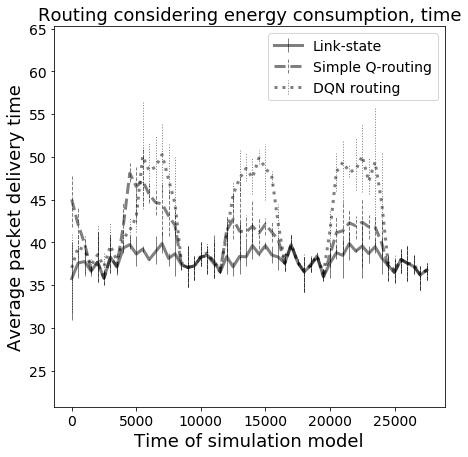

   Link-state  Simple Q-routing  DQN routing
0        38.0              40.1         42.0


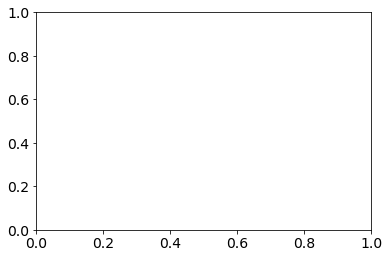

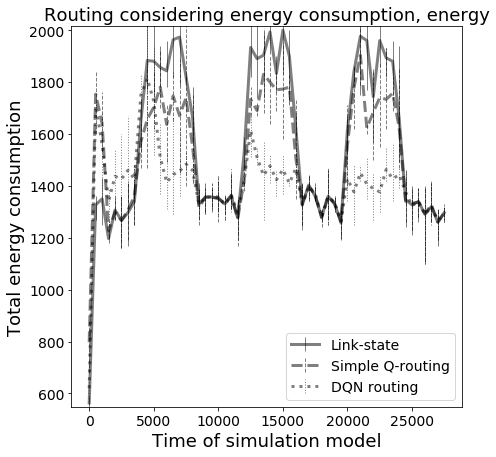

   Link-state  Simple Q-routing  DQN routing
0     87183.3           84273.3      78946.7


In [52]:
results_multi_conv_ng_test_ls = read_multi_run('logs/conveyor_energy_test/ls_en1.{}.csv', prefixes=['time', 'energy'])
results_multi_conv_ng_test_sq = read_multi_run('logs/conveyor_energy_test/simple_q_en1.{}.csv', prefixes=['time', 'energy'])
results_multi_conv_ng_test_dqn = read_multi_run('logs/conveyor_energy_test/dqn_en1.{}.csv', prefixes=['time', 'energy'])
ress=[('Link-state', results_multi_conv_ng_test_ls),
                       ('Simple Q-routing', results_multi_conv_ng_test_sq),
                       ('DQN routing', results_multi_conv_ng_test_dqn)]
plot_multi_graph('Routing considering energy consumption, time', prefix='time', ress=ress,
                 elw=1, font_size=18, legend_size=14, color=False, figsize=(7,7), save_path="bhs-1-main_bw.pdf")
print(count_mean_multi(ress, prefix='time'))
plot_multi_graph('Routing considering energy consumption, energy', prefix='energy',
                 ylabel='Total energy consumption', ress=ress,
                 elw=1, font_size=18, legend_size=14, color=False, figsize=(7,7), save_path="bhs-1-main-energy_bw.pdf")
print(count_mean_multi(ress, prefix='energy', f=np.sum))

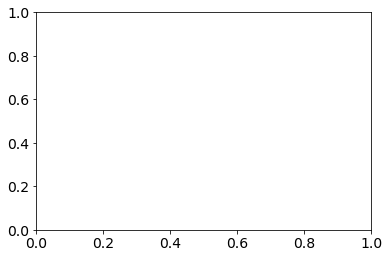

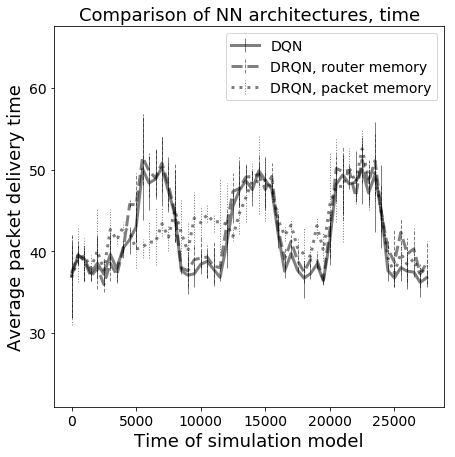

    DQN  DRQN, router memory  DRQN, packet memory
0  42.0                 42.9                 42.9


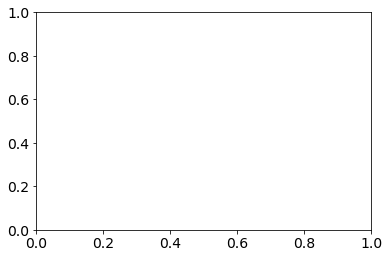

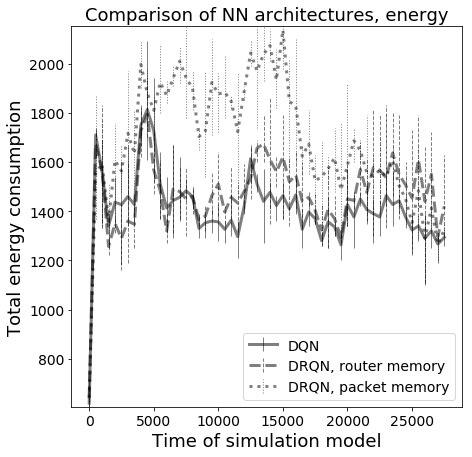

       DQN  DRQN, router memory  DRQN, packet memory
0  78946.7              82236.7              94231.3


In [54]:
results_multi_conv_ng_test_dqn_rnn_pp = read_multi_run('logs/conveyor_energy_test/dqn_rnn_per_pkg_en1.{}.csv',
                                                       prefixes=['time', 'energy'])
results_multi_conv_ng_test_dqn_rnn = read_multi_run('logs/conveyor_energy_test/dqn_rnn_en1.{}.csv',
                                                    prefixes=['time', 'energy'])
ress=[('DQN', results_multi_conv_ng_test_dqn),
                       ('DRQN, router memory', results_multi_conv_ng_test_dqn_rnn),
                       ('DRQN, packet memory', results_multi_conv_ng_test_dqn_rnn_pp)]
plot_multi_graph('Comparison of NN architectures, time', prefix='time', ress=ress,
                 elw=1, font_size=18, legend_size=14, color=False, figsize=(7,7), save_path="bhs-1-nns_bw.pdf")
print(count_mean_multi(ress, prefix='time'))
plot_multi_graph('Comparison of NN architectures, energy', prefix='energy',
                 ylabel='Total energy consumption', ress=ress,
                 elw=1, font_size=18, legend_size=14, color=False, figsize=(7,7), save_path="bhs-1-nns-energy_bw.pdf")
print(count_mean_multi(ress, prefix='energy', f=np.sum))

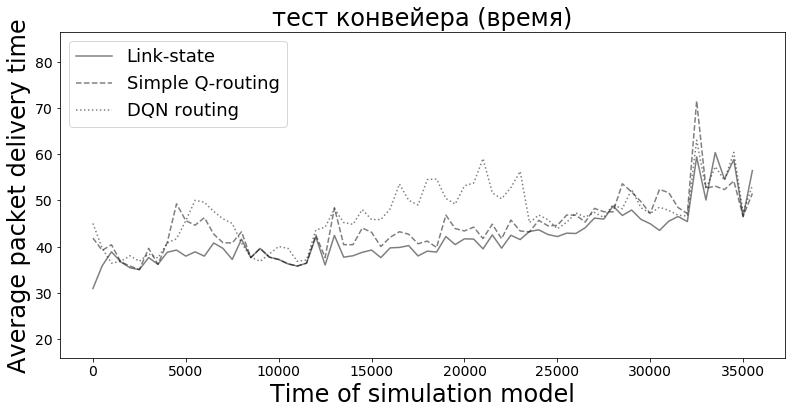

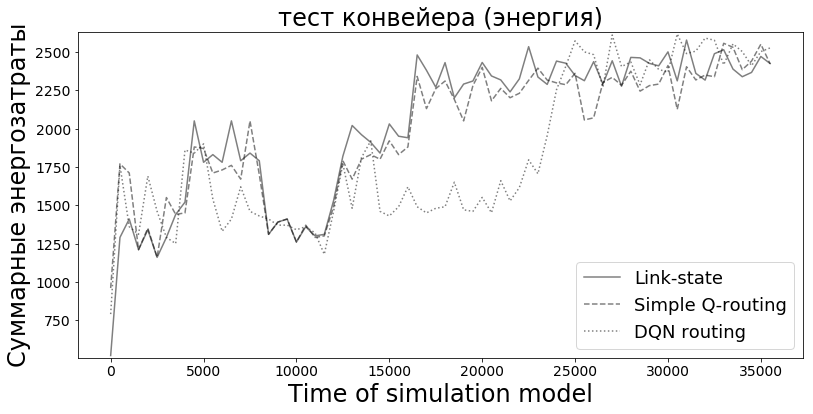

In [55]:
results_conv_ng2_test_ls = pd.read_csv('logs/conveyor_energy_test_2/ls.1.csv')
results_conv_ng2_test_sq = pd.read_csv('logs/conveyor_energy_test_2/simple_q_en06.1.csv')
results_conv_ng2_test_dqn = pd.read_csv('logs/conveyor_energy_test_2/dqn_en06.1.csv')
plot_graph('тест конвейера (время)', prefix='time',
           ress=[('Link-state', results_conv_ng2_test_ls),
                 ('Simple Q-routing', results_conv_ng2_test_sq),
                 ('DQN routing', results_conv_ng2_test_dqn)])
plot_graph('тест конвейера (энергия)', prefix='energy', ylabel='Суммарные энергозатраты',
           ress=[('Link-state', results_conv_ng2_test_ls),
                 ('Simple Q-routing', results_conv_ng2_test_sq),
                 ('DQN routing', results_conv_ng2_test_dqn)])

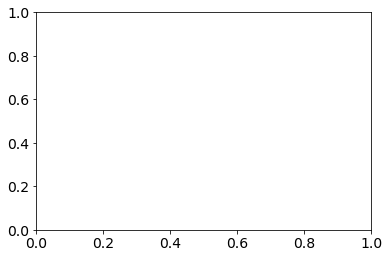

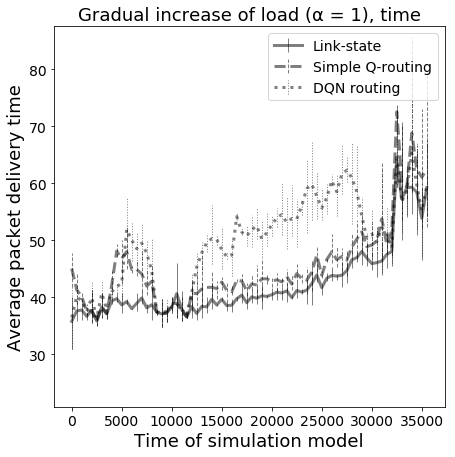

   Link-state  Simple Q-routing  DQN routing
0        42.3              45.3         49.8


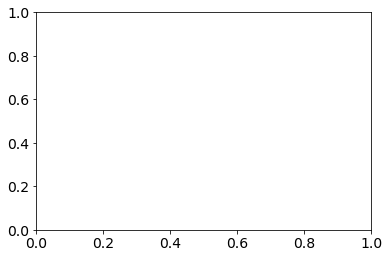

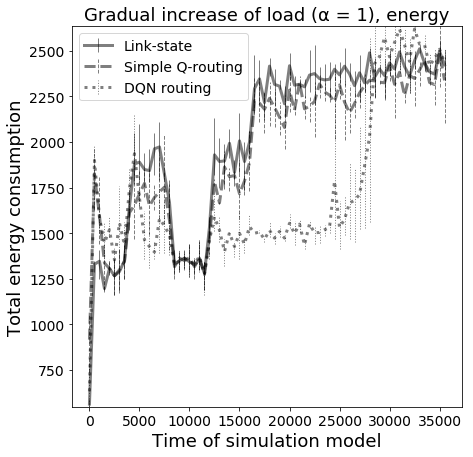

   Link-state  Simple Q-routing  DQN routing
0    145111.7          140146.0     123984.3


In [57]:
results_multi_conv_ng2_test_ls = read_multi_run('logs/conveyor_energy_test_2/ls.{}.csv',
                                                prefixes=['time', 'energy'])
results_multi_conv_ng2_test_sq = read_multi_run('logs/conveyor_energy_test_2/simple_q_hmm.{}.csv',
                                                prefixes=['time', 'energy'])
results_multi_conv_ng2_test_dqn = read_multi_run('logs/conveyor_energy_test_2/dqn_hmm.{}.csv',
                                                 prefixes=['time', 'energy'])
ress=[('Link-state', results_multi_conv_ng2_test_ls),
                       ('Simple Q-routing', results_multi_conv_ng2_test_sq),
                       ('DQN routing', results_multi_conv_ng2_test_dqn)]
plot_multi_graph('Gradual increase of load (α = 1), time', prefix='time', ress=ress,
                 elw=1, font_size=18, legend_size=14, color=False, figsize=(7,7), save_path="bhs-2-a1_bw.pdf")
print(count_mean_multi(ress, prefix='time'))
plot_multi_graph('Gradual increase of load (α = 1), energy', prefix='energy', ylabel='Total energy consumption',
                 ress=ress, elw=1, font_size=18, legend_size=14, color=False, figsize=(7,7), save_path="bhs-2-a1-energy_bw.pdf")
print(count_mean_multi(ress, prefix='energy', f=np.sum))

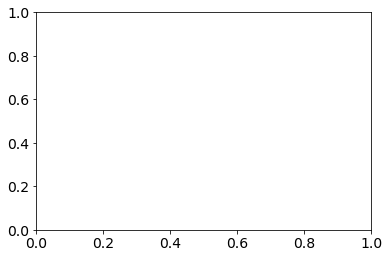

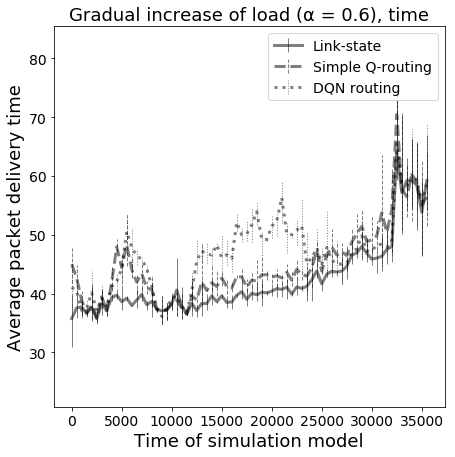

   Link-state  Simple Q-routing  DQN routing
0        42.3              44.8         46.8


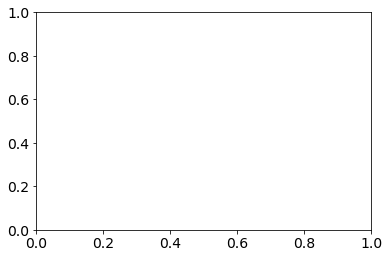

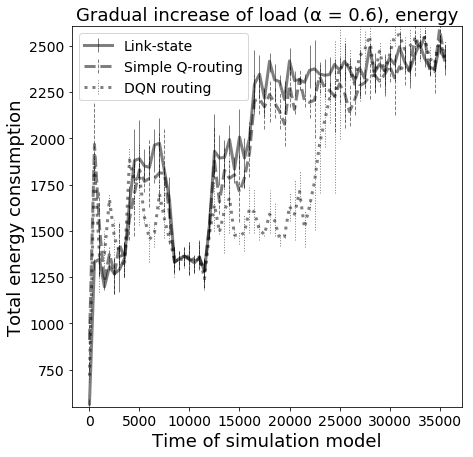

   Link-state  Simple Q-routing  DQN routing
0    145111.7          141613.3     132193.0


In [59]:
results_multi_conv_ng2_test_ls = read_multi_run('logs/conveyor_energy_test_2/ls.{}.csv',
                                                prefixes=['time', 'energy'])
results_multi_conv_ng2_test_sq = read_multi_run('logs/conveyor_energy_test_2/simple_q_en06.{}.csv',
                                                prefixes=['time', 'energy'])
results_multi_conv_ng2_test_dqn = read_multi_run('logs/conveyor_energy_test_2/dqn_en06.{}.csv',
                                                 prefixes=['time', 'energy'])
ress=[('Link-state', results_multi_conv_ng2_test_ls),
                       ('Simple Q-routing', results_multi_conv_ng2_test_sq),
                       ('DQN routing', results_multi_conv_ng2_test_dqn)]
plot_multi_graph('Gradual increase of load (α = 0.6), time', prefix='time', ress=ress,
                 elw=1, font_size=18, legend_size=14, color=False, figsize=(7,7), save_path="bhs-2-a06_bw.pdf")
print(count_mean_multi(ress, prefix='time'))
plot_multi_graph('Gradual increase of load (α = 0.6), energy', prefix='energy', ylabel='Total energy consumption',
                 ress=ress, elw=1, font_size=18, legend_size=14, color=False, figsize=(7,7),
                 save_path="bhs-2-a06-energy_bw.pdf")
print(count_mean_multi(ress, prefix='energy', f=np.sum))

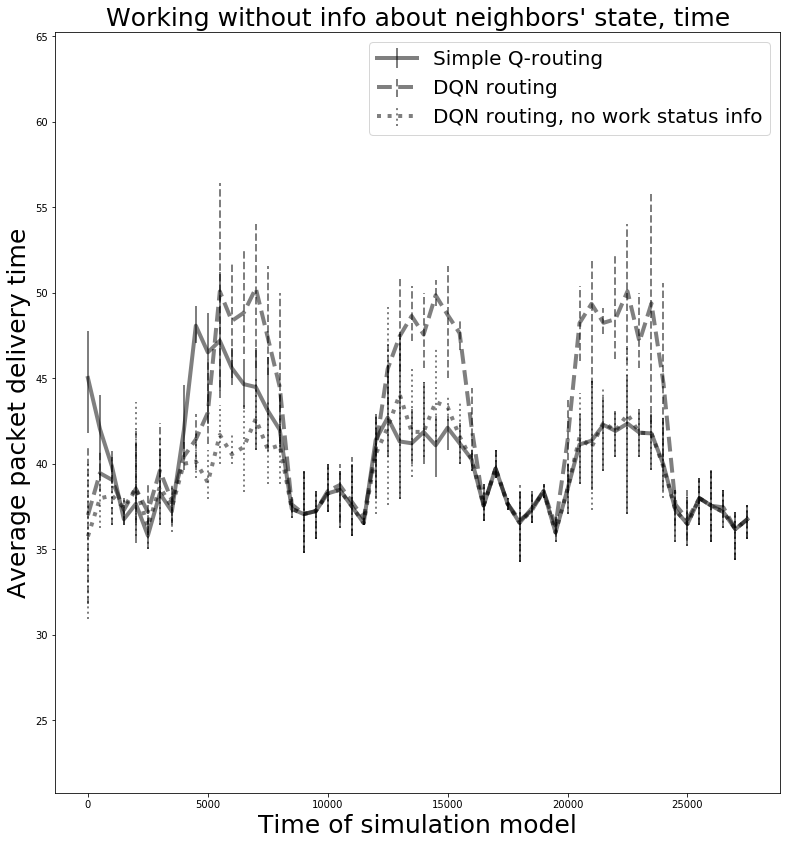

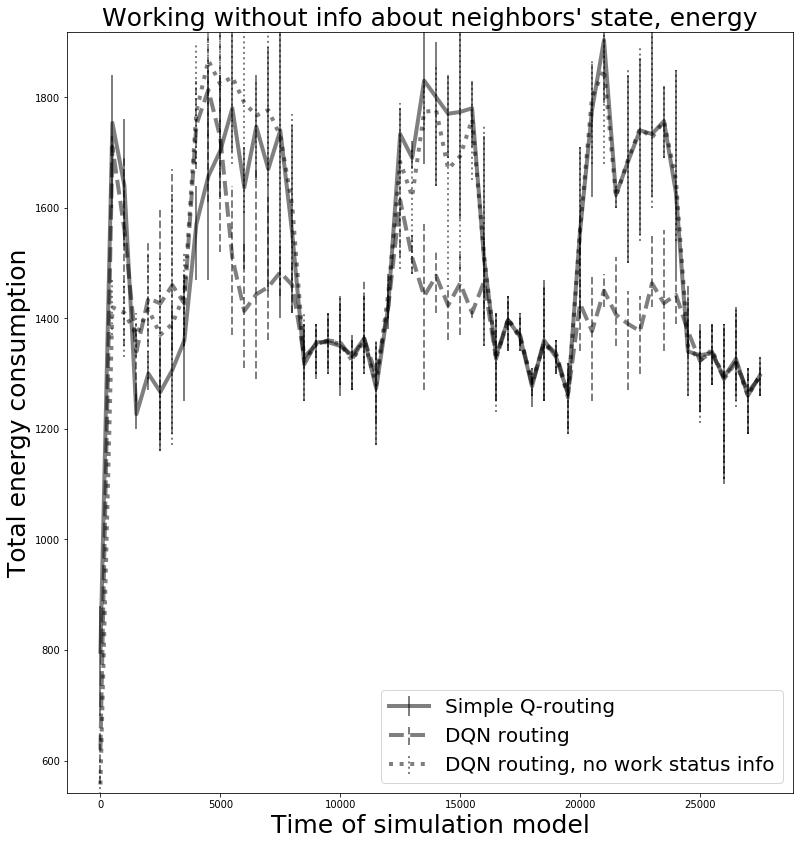

In [86]:
results_multi_conv_ng_test_dqn_no_inp = read_multi_run('logs/conveyor_energy_test/dqn_no_inp.{}.csv',
                                                       prefixes=['time', 'energy'])
plot_multi_graph('Working without info about neighbors\' state, time', prefix='time',
                 ress=[('Simple Q-routing', results_multi_conv_ng_test_sq),
                       ('DQN routing', results_multi_conv_ng_test_dqn),
                       ('DQN routing, no work status info', results_multi_conv_ng_test_dqn_no_inp)],
                 figsize=(13, 14), font_size=25, legend_size=20, lw=4, elw=2)
plot_multi_graph('Working without info about neighbors\' state, energy', prefix='energy', ylabel='Total energy consumption',
                 ress=[('Simple Q-routing', results_multi_conv_ng_test_sq),
                       ('DQN routing', results_multi_conv_ng_test_dqn),
                       ('DQN routing, no work status info', results_multi_conv_ng_test_dqn_no_inp)],
                 figsize=(13, 14), font_size=25, legend_size=20, lw=4, elw=2)